In [6]:
import numpy as np
import nibabel as nib
import dsiadapt as dsi
from dipy.viz import fvtk
from dipy.data import get_sphere
import dsitool as dst

%pylab inline
np.set_printoptions(threshold=numpy.nan)


Welcome to pylab, a matplotlib-based Python environment [backend: module://IPython.kernel.zmq.pylab.backend_inline].
For more information, type 'help(pylab)'.


In [7]:
## Load ODF sphere directions
sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(2)

In [8]:
files = np.array(['DSI11_invivo_cc', 'DSI11_exvivo_cc', 'DSI15_exvivo_cc', 'DSI17_exvivo_cc'])

In [9]:
# Load fov and mdd needed for ODF reconstruction
# fov and mdd data are generated by script s-figure2-pdf
# The four elements are in order to in vivo DSI11, ex vivo DSI11, ex vivo DSI15, ex vivo DSI17
fovarr = np.load('results/fov.npy');
mddarr = np.load('results/mdd.npy');

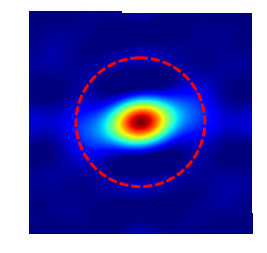

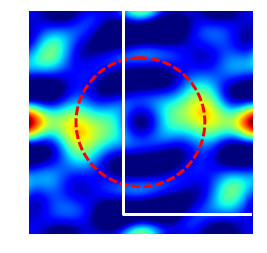

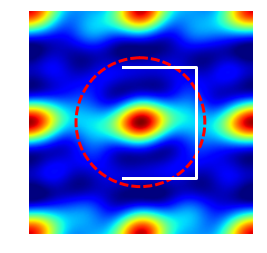

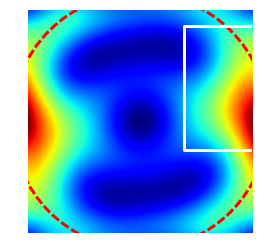

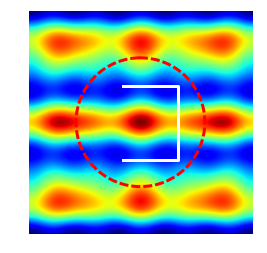

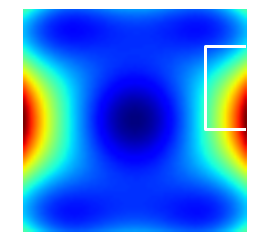

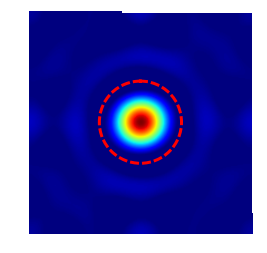

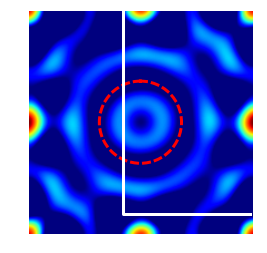

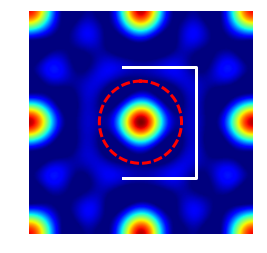

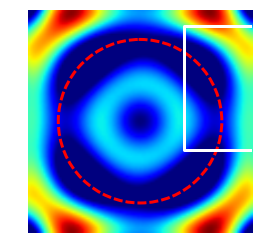

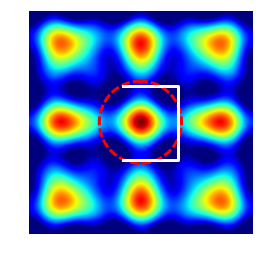

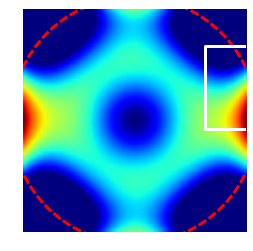

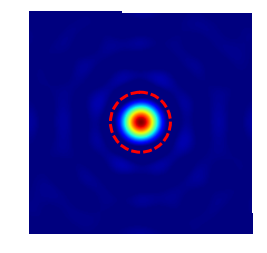

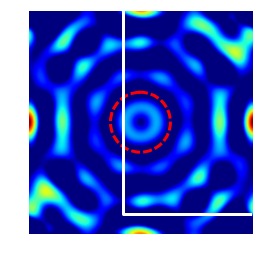

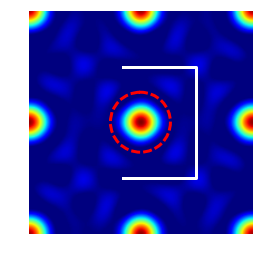

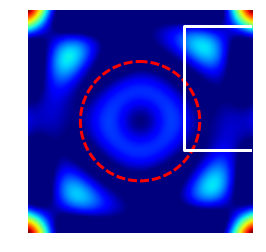

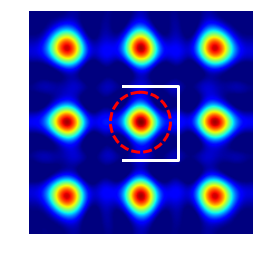

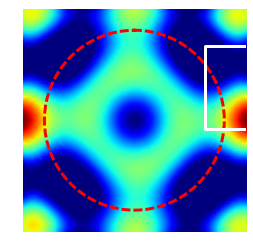

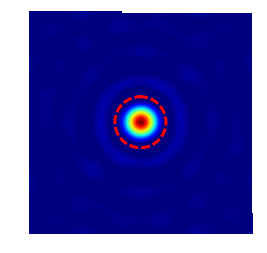

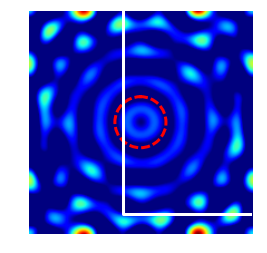

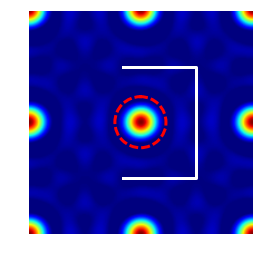

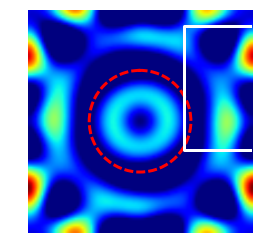

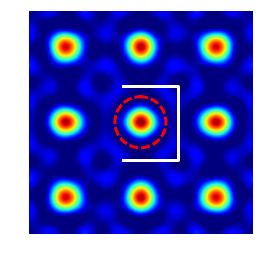

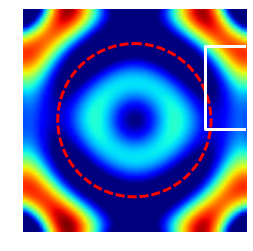

In [10]:
qgridsz = 201;
pdfwgtorder = 2;

for ii in np.arange(files.shape[0]):
    filename = files[ii]
    gtab = dst.loadgtab(filename);
    fov = fovarr[ii];
    mdd = mddarr[ii];
    
    fwidth = np.inf;
    integdistance = np.min([mdd, fov/2]);
    rend = np.round(integdistance / fov * qgridsz);
    
    for downratio in np.array([1., 2., 3.]):
        data = dst.loaddata(filename);
        datadown = dst.downsample(data, gtab, downratio);
        dsimodel = dsi.DiffusionSpectrumModel(gtab, qgrid_size=qgridsz, filter_width=fwidth, r_start=0, r_end=rend, r_step=0.2);
        dsifit = dsimodel.fit(datadown);
        
        odf = dsifit.odf(sphere, pdfwgtorder);
        odfvox = odf[2, 0, 0]
        
        pdf = dsifit.pdf(normalized=False, clipped=False); 
        pdfvox = pdf[2, 0, 0]
            
        pdfvox = pdfvox / pdfvox.max()
        pdfslice = np.rot90(pdfvox[:, :, qgridsz//2 + 1])
        pdfslice_clipped = np.clip(pdfslice, 0, pdfslice.max())
        pdfslice_clipped_fov = pdfslice_clipped[qgridsz//2-qgridsz//(2*downratio): qgridsz//2+qgridsz//(2*downratio)+1, qgridsz//2-qgridsz//(2*downratio): qgridsz//2+qgridsz//(2*downratio)+1];
        pdfslice_clipped_fov_weighted = dst.weight(pdfslice_clipped_fov, pdfwgtorder); 
            
        # save odf
        r = fvtk.ren();
        fvtk.add(r, fvtk.sphere_funcs(odfvox, sphere));
        odfname = 'figure/figure7/' + filename + '_odf_sub' + str(downratio) + '.png';
        fvtk.record(r, n_frames=1, out_path=odfname, size=(600,600))
        #fvtk.show(r)
            
        # save pdf
        fig = figure()
        imshow(pdfslice_clipped);
        circle = Circle((qgridsz//2, qgridsz//2), radius = rend, color = 'r', fill=False, linestyle = 'dashed', linewidth=3.)
        rect = Rectangle((qgridsz//2-qgridsz//(2*downratio), qgridsz//2-qgridsz//(2*downratio)), qgridsz//downratio, qgridsz//downratio, fill=False, color='w', linestyle = 'solid', linewidth=3.)
        fig.gca().add_artist(circle)
        fig.gca().add_artist(rect)
        axis('off');
        pdfname = 'figure/figure7/' + filename + '_pdf_sub' + str(downratio) + '.png';
        savefig(pdfname, dpi = 600)
            
        # save weighted pdf
        fig = figure()
        imshow(pdfslice_clipped_fov_weighted);
        circle = Circle((qgridsz//(2*downratio), qgridsz//(2*downratio)), radius = rend, color = 'r', fill=False, linestyle = 'dashed', linewidth=3.)
        fig.gca().add_artist(circle)
        fig.gca().add_artist(rect)
        axis('off');
        pdfname = 'figure/figure7/' + filename + '_weightedpdf_sub' + str(downratio) + '.png';
        savefig(pdfname, dpi = 600)